In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#figname.savefig('filename.pdf', bbox_inches='tight', format='pdf', dpi=1000)

In [ ]:
RE = "Wind_Wallonie_Elia"

try:
    import google.colab
    address    = "/content/drive/My Drive/Sogang/Research/Dissertation/Colab/results/"

except:
    address    = "results/"

data_test_csv   = pd.read_csv(address+RE+'_19.csv', index_col=0)
data_price = pd.read_csv(address+'Elia_Imbalance_Price_19.csv', index_col=0)
data_test_csv['Price(€)']  = data_price['Positive imbalance price']

In [ ]:
# Data Preprocessing
 
RE_Capacity3 = max(data_test_csv['Power(MW)'])
max_price = max(data_price['Marginal incremental price'])
 
unit    = 1 #unit: 15 minute
E_max   = 0.15 #p.u.
P_max   = E_max
tdelta  = unit/4
soc_min = 0.1
soc_max = 0.9
a0 = -1.031; a1 = 35; a2 = 3.685; a3 = 0.2156; a4 = 0.1178; a5 = 0.3201
b0 = 0.1463; b1 = 30.27; b2 = 0.1037; b3 = 0.0584; b4 = 0.1747; b5 = 0.1288
c0 = 0.1063; c1 = 62.49; c2 = 0.0437; d0 = 0.0712; d1 = 61.4; d2 = 0.0288
N = 130*215*E_max/0.1
beta = 10/max_price
 
size_test0  = int(len(data_test_csv)/unit)
data_test0 = []; data_test = []; price_test0 = []; price_test = []; time_test = []
for i in range(size_test0):
    data_test0  += [round(pd.Series.mean(data_test_csv['Power(MW)'][i*unit:(i+1)*unit])/RE_Capacity3, 3)]
    price_test0 += [round(pd.Series.mean(data_test_csv['Price(€)'][i*unit:(i+1)*unit])/max_price, 3)]
    if data_test0[i] > 0: data_test += [data_test0[i]]; price_test += [price_test0[i]]; time_test += [data_test_csv.index[i]]

In [ ]:
model  = ['FB', 'Arbitrage', 'FBComp', 'DeepComp', 'DeepBid']
metric = ['MAE', 'MBE', 'Profit', 'Penalty', 'Battery_Use', 'Revenue']
 
model_bid  = ["_Model4_FB.csv", "_Model4_FB.csv", "_Model4_FB.csv", "_Model6_DeepComp.csv", "_Model7_DeepBid.csv"]
model_rat  = ['0', "_Model5_Arbitrage.csv", '1', '1', "_Model7_DeepBid.csv"]
 
mbe = []
profit  = []
penalty = []
bat_use = []
revenue = []
Bid = []
SoC = []
 
results = {}
for m in range(len(model)):
    select_test = np.array(pd.read_csv(address+RE+model_bid[m])['0'])
    if model_rat[m]=='0':   select_test_rat = np.array([0.0 for _ in range(len(select_test))])
    elif model_rat[m]=='1': select_test_rat = np.array([1.0 for _ in range(len(select_test))])
    else:                   select_test_rat = np.array(pd.read_csv(address+RE+model_rat[m])['1'])
    select_test_real = np.array(data_test[1:])
    select_test_price = np.array(price_test[1:])
    
    E = E_max/2
    mbe += [[]]
    profit  += [[]]
    penalty += [[]]
    bat_use += [[]]
    revenue += [[]]
    Bid += [[]]
    SoC += [[]]
    for i in range(len(select_test)):
        bid = select_test[i]
        gen = select_test_real[i]
        rat = select_test_rat[i]
        imb = select_test_price[i]
        
        soc = E/E_max
        Voc = a0*np.exp(-a1*soc) + a2 + a3*soc - a4*soc**2 + a5*soc**3
        Rs  = b0*np.exp(-b1*soc) + b2 + b3*soc - b4*soc**2 + b5*soc**3
        Rts = c0*np.exp(-c1*soc) + c2
        Rtl = d0*np.exp(-d1*soc) + d2
        R   = Rs + Rts + Rtl
    
        I_cmax = 1000000*E_max*(soc_max - soc)/N/(Voc*tdelta)
        I_dmax = 1000000*E_max*(soc - soc_min)/N/(Voc*tdelta)
        p_cmax = N*(Voc*I_cmax + I_cmax**2*R)
        p_dmax = N*(Voc*I_dmax - I_dmax**2*R)
    
        P_cmax = p_cmax/1000000; P_dmax = p_dmax/1000000
        if 'Arbitrage' in model_rat[m]: rat = rat/(bid-gen)
        P_c = min(max(rat*(gen-bid), 0), P_max, P_cmax)
        P_d = min(max(rat*(bid-gen), 0), P_max, P_dmax)
        p_c = 1000000*P_c/N; p_d = 1000000*P_d/N
    
        I_c = -(Voc - np.sqrt(Voc**2 + 4*R*p_c))/(2*R)
        I_d = (Voc - np.sqrt(Voc**2 - 4*R*p_d))/(2*R)
        if not np.isclose(p_c, 0):
            eff_c = (Voc*I_c)/p_c
            E = E + eff_c*P_c*tdelta
            disp = gen - P_c
            if 'Arbitrage' in model_rat[m]: bid = bid - P_c
        elif not np.isclose(p_d, 0):
            eff_d = p_d/(Voc*I_d)
            E = E - (1/eff_d)*P_d*tdelta
            disp = gen + P_d
            if 'Arbitrage' in model_rat[m]: bid = bid + P_d
        else:
            disp = gen
        
        mbe[m] += [abs(bid - disp)]
        profit[m]  += [(imb*disp)*tdelta]
        penalty[m] += [(imb*abs(bid-disp))*tdelta]
        bat_use[m] += [beta*(P_c+P_d)*tdelta]
        revenue[m] += [(imb*disp - imb*abs(bid-disp) - beta*(P_c+P_d))*tdelta]
        Bid[m] += [bid]
        SoC[m] += [soc]
    
    MAE_test = round(100*np.mean(np.abs(select_test_real - select_test)),2)
    MBE_test = round(100*np.mean(mbe[m]),2)
    PFT_test = round(max_price*RE_Capacity3*np.mean(profit[m]),3)
    PEN_test = round(max_price*RE_Capacity3*np.mean(penalty[m]),3)
    BAT_test = round(max_price*RE_Capacity3*np.mean(bat_use[m]),3)
    REV_test = round(max_price*RE_Capacity3*np.mean(revenue[m]),3)
 
    results[model[m]] = [MAE_test, MBE_test, PFT_test, PEN_test, BAT_test, REV_test]
 
results_df = pd.DataFrame(results, index = metric)
results_df

,FB,Arbitrage,FBComp,DeepComp,DeepBid
MAE,2.460,2.460,2.460,2.550,4.030
MBE,2.460,2.460,0.490,0.110,1.050
Profit,203.600,213.646,203.579,203.679,210.386
Penalty,22.315,22.315,4.787,0.647,1.340
Battery_Use,0.000,7.845,4.989,6.216,7.837
Revenue,181.286,183.487,193.803,196.816,201.208


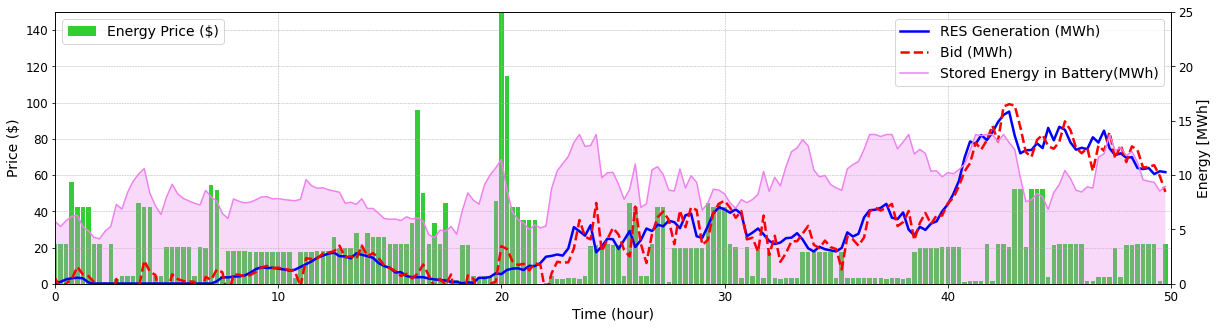

In [ ]:
eg_start = 930
eg_end   = 1130
eg_len   = eg_end - eg_start
 
gen_eg = RE_Capacity3*np.array(data_test[eg_start+1:eg_end+1])*tdelta
bid_eg = RE_Capacity3*np.array(Bid[-1][eg_start:eg_end])*tdelta
soc_eg = RE_Capacity3*E_max*np.array(SoC[-1][eg_start:eg_end])
imb_eg = max_price*np.array(price_test[eg_start+1:eg_end+1])*tdelta
 
fig_deepbid_eg = plt.figure(figsize=(20,5))
plt.bar(np.arange(eg_len)/4, imb_eg, color='limegreen', width=0.2, label="Energy Price ($)")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Time (hour)", fontsize=14)
plt.ylabel("Price ($)", fontsize=14)
plt.xlim([0,eg_len/4])
plt.ylim([0,150])
plt.legend(fontsize=14, loc=2)
plt.grid(linestyle='--', linewidth=0.5)
plt.twinx()
plt.plot(np.arange(eg_len)/4, gen_eg, 'b', linewidth=2.5, label="RES Generation (MWh)")
plt.plot(np.arange(eg_len)/4, bid_eg, 'r--', linewidth=2.5, label="Bid (MWh)")
plt.plot(np.arange(eg_len)/4, soc_eg, color='violet', label="Stored Energy in Battery(MWh)")
plt.fill_between(np.arange(eg_len)/4, soc_eg, 0, facecolor='violet', alpha=0.3)
plt.yticks(fontsize = 12)
plt.ylabel("Energy [MWh]", fontsize=14)
plt.ylim([0,25])
plt.legend(fontsize=14, loc=1)
plt.show()

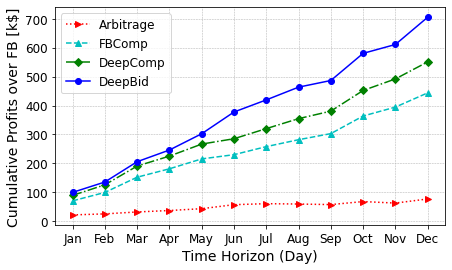

In [ ]:
color = ["m", "r", "c", "g", "b"]
colorl = ["m:", "r:", "c--", "g-.", "b"]
marker = ['*', '>', '^', 'D', 'o']

month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_len = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
revenue_month = [[[]] for _ in range(len(model))]
for m in range(len(model)):
    for i in range(1, len(time_test)):
        if time_test[i][3:5] == time_test[i-1][3:5]:
            revenue_month[m][-1] += [revenue[m][i-1]]
        else:
            revenue_month[m] += [[]]
            revenue_month[m][-1] += [revenue[m][i-1]]
    
    for j in range(len(revenue_month[m])):
        revenue_month[m][j] = np.mean(revenue_month[m][j])
  
revenue_month = np.round(max_price*RE_Capacity3*np.array(revenue_month),3)
revenue_cum = [[] for _ in range(len(model))]
for m in range(len(model)):
    for i in range(len(revenue_month[m])):
        revenue_cum[m] += [sum(revenue_month[m][:i+1]) * 96/unit * month_len[i] / 1000]

PoF_cum = [[] for _ in range(len(model)-1)] # Profit over FB
for m in range(1,len(model)):
    for i in range(len(revenue_cum[m])):
        PoF_cum[m-1] += [revenue_cum[m][i] - revenue_cum[0][i]]

fig_rev = plt.figure(figsize=(7,4))
for m in range(1,len(model)):
    plt.plot(month, PoF_cum[m-1], colorl[m], marker=marker[m], label=model[m])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Time Horizon (Day)", fontsize=14)
plt.ylabel("Cumulative Profits over FB [k$]", fontsize=14)
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=12, loc=2)
plt.show()

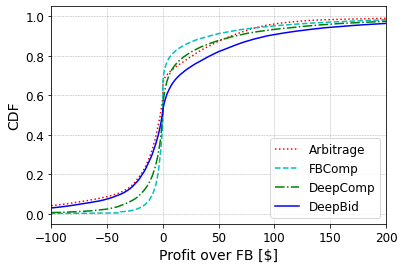

In [ ]:
PoF = [[] for _ in range(len(model)-1)] # Profit over FB
for m in range(1,len(model)):
    for i in range(len(revenue[m])):
        PoF[m-1] += [revenue[m][i] - revenue[0][i]]

cdf = []
for m in range(len(PoF)):
    cdf += [np.arange(1, len(PoF[m])+1) / len(PoF[m])]

fig_cdf = plt.figure()
for m in range(1,len(model)):
    plt.plot(np.sort(max_price*RE_Capacity3*np.array(PoF[m-1])), cdf[m-1], colorl[m], label=model[m])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Profit over FB [$]", fontsize=14)
plt.ylabel("CDF", fontsize=14)
plt.xlim([-100,200])
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=12, loc=4)
plt.show()